# Lab15: Deep Reinforcement Learning
---
111062117 黃祥陞

In this lab, we introduce deep reinforcement learning, which utilizes function approximation to estimate value / policy for all unseen states such that given a state, we can estimate its value or action. We can use what we have learned in machine learning (e.g. regression, DNN) to achieve it.

## Setup

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import skimage.transform
from IPython.display import Image, display

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls

In [31]:
gpus = tf.config.list_physical_devices("GPU") 
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [32]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
from ple.games.flappybird import FlappyBird
from ple import PLE

game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

test_game = FlappyBird()
test_env = PLE(test_game, fps=30, display_screen=False)
test_env.reset_game()

In [33]:
path = './movie_f' 
if not os.path.exists(path):
    os.makedirs(path)

In [34]:
hparas = {
    'image_size': 84,
    'num_stack': 4,
    'action_dim': len(env.getActionSet()),
    'hidden_size': 256,
    'lr': 0.0001,
    'gamma': 0.99,
    'lambda': 0.95,
    'clip_val': 0.2,
    'ppo_epochs': 8,
    'test_epochs': 1,
    'num_steps': 512,
    'mini_batch_size': 64,
    'target_reward': 200,
    'max_episode': 30000,
}

In [35]:
# Please do not modify this method
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    
    return clip


In [36]:
def preprocess_screen(screen):
    screen = skimage.transform.rotate(screen, -90, resize=True)
    screen = screen[:400, :]
    screen = skimage.transform.resize(screen, [hparas['image_size'], hparas['image_size'], 1])
    return screen.astype(np.float32)

def frames_to_state(input_frames):
    if(len(input_frames) == 1):
        state = np.concatenate(input_frames*4, axis=-1)
    elif(len(input_frames) == 2):
        state = np.concatenate(input_frames[0:1]*2 + input_frames[1:]*2, axis=-1)
    elif(len(input_frames) == 3):
        state = np.concatenate(input_frames + input_frames[2:], axis=-1)
    else:
        state = np.concatenate(input_frames[-4:], axis=-1)

    return state

## Actor-Critic Neural Network
This section defines an Actor-Critic neural network used for simultaneous learning of policy and value in reinforcement learning models. The network consists of a shared feature extraction part and separate output layers for the policy (Actor) and value (Critic).

In [37]:
class ActorCriticNetwork(tf.keras.Model):
    def __init__(self, hparas):
        super().__init__()

        self.feature_extractor = tf.keras.Sequential([
          # Convolutional Layers
          tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=4),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1),
          tf.keras.layers.ReLU(),
          # Embedding Layers
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(hparas['hidden_size']),
          tf.keras.layers.ReLU(),
        ])

        # Actor Network
        self.actor = tf.keras.layers.Dense(hparas['action_dim'], activation='softmax')
        # Critic Network
        self.critic = tf.keras.layers.Dense(1, activation = None)

    def call(self, input):
        x = self.feature_extractor(input)
        action_logits = self.actor(x)
        value = self.critic(x)
        return action_logits, value

## PPO (Proximal Policy Optimization)
This section implements the core components of the PPO (Proximal Policy Optimization) reinforcement learning algorithm. The Agent class includes the definition and training process of the agent, which involves:
1. Initializing the Actor-Critic model and optimizer.
2. Performing policy gradient updates using mini-batches.
3. Applying the PPO loss function to update both the policy (Actor) and value (Critic) networks.

In [38]:
class Agent():
    def __init__(self, hparas):
        self.gamma = hparas['gamma']
        # self.optimizer = tf.keras.optimizers.Adam(learning_rate=hparas['lr'])
        self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=hparas['lr']) # for mac
        self.actor_critic = ActorCriticNetwork(hparas)
        self.clip_pram = hparas['clip_val']
    
    def ppo_iter(self, mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.shape[0]
        for _ in range(batch_size // mini_batch_size):
            rand_ids = tf.convert_to_tensor(np.random.randint(0, batch_size, mini_batch_size), dtype=tf.int32)
            yield tf.gather(states, rand_ids), tf.gather(actions, rand_ids), tf.gather(log_probs, rand_ids), \
             tf.gather(returns, rand_ids), tf.gather(advantage, rand_ids)
    
    def ppo_update(self, ppo_epochs, mini_batch_size, states, actions, log_probs, discount_rewards, advantages):       
        total_actor_loss = 0
        total_critic_loss = 0
        for _ in range(ppo_epochs):
            for state, action, old_log_probs, reward, advantage in self.ppo_iter(mini_batch_size, states, actions, log_probs, discount_rewards, advantages):
                reward = tf.expand_dims(reward, axis=-1)

                with tf.GradientTape() as tape:
                    prob, value = self.actor_critic(state, training=True)
                    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
                    entropy = tf.math.reduce_mean(dist.entropy())
                    new_log_probs = dist.log_prob(action)

                    # PPO ratio
                    ratio = tf.math.exp(new_log_probs - old_log_probs)
                    surr1 = ratio * advantage
                    surr2 = tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram) * advantage

                    actor_loss = tf.math.negative(tf.math.reduce_mean(tf.math.minimum(surr1, surr2))) - 0.1 * entropy
                    critic_loss = 0.5 * tf.math.reduce_mean(kls.mean_squared_error(reward, value))

                    total_loss = actor_loss + critic_loss
            
                # single optimizer
                grads = tape.gradient(total_loss, self.actor_critic.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.actor_critic.trainable_variables))
      
                total_actor_loss += actor_loss
                total_critic_loss += critic_loss
        return total_actor_loss, total_critic_loss

**compute_gae function**: Computes Generalized Advantage Estimation (GAE) to reduce variance in value function estimation and improve training stability in reinforcement learning.

In [39]:
# https://arxiv.org/pdf/1506.02438.pdf
# Equation 16
def compute_gae(rewards, masks, values, gamma, LAMBDA):
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * masks[i] - values[i]
        gae = delta + gamma * LAMBDA * masks[i] * gae
        returns.append(gae + values[i])

    returns.reverse()
    return returns

**test_reward function**: Evaluates the agent’s performance under the current policy by interacting with the environment and calculating the total reward

In [40]:
def test_reward(test_env, agent):
    total_reward = 0
    # Reset the environment
    test_env.reset_game()
    input_frames = [preprocess_screen(test_env.getScreenGrayscale())]

    while not test_env.game_over():

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        action = np.argmax(prob[0].numpy())
        reward = test_env.act(test_env.getActionSet()[action])
        total_reward += reward

        input_frames.append(preprocess_screen(test_env.getScreenGrayscale()))

    return total_reward

## Training
This section implements the training process of the agent using the PPO algorithm, where the agent interacts with the environment to collect data such as states, actions, rewards, and values. The training involves calculating Generalized Advantage Estimation (GAE) and returns to update the Actor-Critic model using PPO loss. The performance of the agent is periodically evaluated in a test environment, and the best-performing models are saved along with video demonstrations. The training process stops early if the agent reaches a reward threshold.

In [43]:
agent = Agent(hparas)
max_episode = hparas['max_episode']
test_per_n_episode = 10
force_save_per_n_episode = 1000
early_stop_reward = 10

start_s = 0
best_reward = -5.0

checkpoint = tf.train.Checkpoint(
    actor_critic = agent.actor_critic,
    optimizer = agent.optimizer,
)

# Load from old checkpoint
checkpoint.restore(tf.train.latest_checkpoint('./save/checkpoints'))

In [44]:
ep_reward = []
total_avgr = []
early_stop = False
avg_rewards_list = []

env.reset_game()

for s in range(0, max_episode):
    if early_stop == True:
        break

    rewards = []
    states = []
    actions = []
    log_probs = []
    masks = []
    values = []

    display_frames = [env.getScreenRGB()]
    input_frames = [preprocess_screen(env.getScreenGrayscale())]

    for step in range(hparas['num_steps']):

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        dist = tfp.distributions.Categorical(probs=prob[0], dtype=tf.float32)
        action = dist.sample(1)
        log_prob = dist.log_prob(action)

        reward = env.act(env.getActionSet()[int(action.numpy())])

        done = env.game_over()

        states.append(state)
        actions.append(action)
        values.append(value[0])
        log_probs.append(log_prob)
        rewards.append(tf.convert_to_tensor(reward, dtype=tf.float32))
        masks.append(tf.convert_to_tensor(1-int(done), dtype=tf.float32))

        display_frames.append(env.getScreenRGB())
        input_frames.append(preprocess_screen(env.getScreenGrayscale()))

        if done:
            env.reset_game()
            input_frames = [preprocess_screen(env.getScreenGrayscale())]
  
    _, next_value = agent.actor_critic(state)
    values.append(next_value[0])

    returns = compute_gae(rewards, masks, values, hparas['gamma'], hparas['lambda'])

    returns = tf.concat(returns, axis=0)
    log_probs = tf.concat(log_probs, axis=0)
    values = tf.concat(values, axis=0)
    states = tf.concat(states, axis=0)
    actions = tf.concat(actions, axis=0)
    advantage = returns - values[:-1]

    a_loss, c_loss = agent.ppo_update(hparas['ppo_epochs'], hparas['mini_batch_size'], states, actions, log_probs, returns, advantage)
    print('[Episode %d]  Actor loss: %.5f, Critic loss: %.5f' % (s, a_loss, c_loss))

    if s % test_per_n_episode == 0:
        # test agent hparas['test_epochs'] times to get the average reward
        avg_reward = np.mean([test_reward(test_env, agent) for _ in range(hparas['test_epochs'])])
        print("Test average reward is %.1f, Current best average reward is %.1f\n" % (avg_reward, best_reward))
        avg_rewards_list.append(avg_reward)

        if avg_reward > best_reward:
            best_reward = avg_reward
            agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
            checkpoint.save(file_prefix = './save/checkpoints/ckpt')

    if s % force_save_per_n_episode == 0:
        agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        checkpoint.save(file_prefix = './save/checkpoints/ckpt')
        clip = make_anim(display_frames, fps=60, true_image=True).rotate(-90)
        clip.write_videofile("movie_f/{}_demo-{}.webm".format('Lab15', s), fps=60)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1, maxduration=120))

    if best_reward >= early_stop_reward:
        early_stop = True

[Episode 0]  Actor loss: 46.51760, Critic loss: 29.55951
Test average reward is -5.0, Current best average reward is -5.0

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-5.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-5.0/assets


Moviepy - Building video movie_f/Lab15_demo-0.webm.
Moviepy - Writing video movie_f/Lab15_demo-0.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-0.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1]  Actor loss: 20.75253, Critic loss: 11.41597
[Episode 2]  Actor loss: 22.37318, Critic loss: 7.12489
[Episode 3]  Actor loss: 19.83409, Critic loss: 6.07308
[Episode 4]  Actor loss: -4.10572, Critic loss: 3.77388
[Episode 5]  Actor loss: -0.55275, Critic loss: 3.99275
[Episode 6]  Actor loss: -4.83064, Critic loss: 2.91717
[Episode 7]  Actor loss: -11.54881, Critic loss: 2.31991
[Episode 8]  Actor loss: -9.28224, Critic loss: 2.01889
[Episode 9]  Actor loss: -4.92250, Critic loss: 2.87908
[Episode 10]  Actor loss: -0.60644, Critic loss: 2.26847
Test average reward is -5.0, Current best average reward is -5.0

[Episode 11]  Actor loss: -8.06043, Critic loss: 1.58998
[Episode 12]  Actor loss: -9.98664, Critic loss: 1.65361
[Episode 13]  Actor loss: -8.00684, Critic loss: 2.48211
[Episode 14]  Actor loss: -4.79898, Critic loss: 2.47781
[Episode 15]  Actor loss: -9.10866, Critic loss: 1.88709
[Episode 16]  Actor loss: -3.07714, Critic loss: 1.94504
[Episode 17]  Actor loss: -4.

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_60_-4.0/assets


[Episode 61]  Actor loss: -4.53185, Critic loss: 0.71323
[Episode 62]  Actor loss: -4.44249, Critic loss: 0.88363
[Episode 63]  Actor loss: -7.74450, Critic loss: 1.11592
[Episode 64]  Actor loss: -4.20176, Critic loss: 0.69091
[Episode 65]  Actor loss: -4.67820, Critic loss: 0.65130
[Episode 66]  Actor loss: -1.39146, Critic loss: 0.63777
[Episode 67]  Actor loss: -2.13848, Critic loss: 0.55238
[Episode 68]  Actor loss: -8.01453, Critic loss: 1.22718
[Episode 69]  Actor loss: -1.46271, Critic loss: 0.63500
[Episode 70]  Actor loss: -5.77354, Critic loss: 0.62409
Test average reward is -5.0, Current best average reward is -4.0

[Episode 71]  Actor loss: -2.45913, Critic loss: 0.38291
[Episode 72]  Actor loss: -7.96658, Critic loss: 0.41008
[Episode 73]  Actor loss: -2.58263, Critic loss: 0.64575
[Episode 74]  Actor loss: -6.32083, Critic loss: 0.40287
[Episode 75]  Actor loss: -6.49897, Critic loss: 0.26529
[Episode 76]  Actor loss: 1.56106, Critic loss: 0.39153
[Episode 77]  Actor los

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_330_-3.0/assets


[Episode 331]  Actor loss: -8.39267, Critic loss: 0.19718
[Episode 332]  Actor loss: -4.71282, Critic loss: 0.28279
[Episode 333]  Actor loss: -4.98034, Critic loss: 0.19471
[Episode 334]  Actor loss: -1.53098, Critic loss: 0.21551
[Episode 335]  Actor loss: -5.36220, Critic loss: 0.45498
[Episode 336]  Actor loss: -6.29855, Critic loss: 0.37706
[Episode 337]  Actor loss: -7.58721, Critic loss: 1.14482
[Episode 338]  Actor loss: -0.84113, Critic loss: 0.41731
[Episode 339]  Actor loss: -6.30652, Critic loss: 0.33589
[Episode 340]  Actor loss: -3.26997, Critic loss: 0.39385
Test average reward is -5.0, Current best average reward is -3.0

[Episode 341]  Actor loss: -6.20124, Critic loss: 0.54732
[Episode 342]  Actor loss: 0.80766, Critic loss: 0.33881
[Episode 343]  Actor loss: -7.32284, Critic loss: 0.80171
[Episode 344]  Actor loss: -1.52489, Critic loss: 0.31322
[Episode 345]  Actor loss: -2.84338, Critic loss: 0.39230
[Episode 346]  Actor loss: -5.26186, Critic loss: 0.33935
[Episod

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1000_-5.0/assets


Moviepy - Building video movie_f/Lab15_demo-1000.webm.
Moviepy - Writing video movie_f/Lab15_demo-1000.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-1000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1001]  Actor loss: -22.71972, Critic loss: 2.53170
[Episode 1002]  Actor loss: 7.08815, Critic loss: 2.53999
[Episode 1003]  Actor loss: -4.21806, Critic loss: 2.15633
[Episode 1004]  Actor loss: -4.51618, Critic loss: 1.80346
[Episode 1005]  Actor loss: -14.19104, Critic loss: 2.53226
[Episode 1006]  Actor loss: -7.40618, Critic loss: 5.06436
[Episode 1007]  Actor loss: 3.45867, Critic loss: 3.66936
[Episode 1008]  Actor loss: 6.26243, Critic loss: 1.76664
[Episode 1009]  Actor loss: 2.85561, Critic loss: 0.64267
[Episode 1010]  Actor loss: 2.73283, Critic loss: 0.92360
Test average reward is -5.0, Current best average reward is -3.0

[Episode 1011]  Actor loss: 3.01719, Critic loss: 0.71967
[Episode 1012]  Actor loss: -9.94059, Critic loss: 1.40181
[Episode 1013]  Actor loss: -7.96518, Critic loss: 1.35091
[Episode 1014]  Actor loss: -9.95650, Critic loss: 1.32476
[Episode 1015]  Actor loss: -11.15296, Critic loss: 1.29335
[Episode 1016]  Actor loss: -11.54468, Critic loss: 

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1110_-2.0/assets


[Episode 1111]  Actor loss: -1.01503, Critic loss: 2.72316
[Episode 1112]  Actor loss: -3.95510, Critic loss: 1.08447
[Episode 1113]  Actor loss: -18.54453, Critic loss: 2.04646
[Episode 1114]  Actor loss: -2.27890, Critic loss: 2.69148
[Episode 1115]  Actor loss: -0.50996, Critic loss: 2.20126
[Episode 1116]  Actor loss: -3.42878, Critic loss: 2.68774
[Episode 1117]  Actor loss: -16.91389, Critic loss: 2.76850
[Episode 1118]  Actor loss: 2.58625, Critic loss: 4.57621
[Episode 1119]  Actor loss: -3.69701, Critic loss: 2.61063
[Episode 1120]  Actor loss: -4.28096, Critic loss: 2.02506
Test average reward is -5.0, Current best average reward is -2.0

[Episode 1121]  Actor loss: -8.19674, Critic loss: 2.14414
[Episode 1122]  Actor loss: -13.61836, Critic loss: 4.86785
[Episode 1123]  Actor loss: -4.31044, Critic loss: 3.36366
[Episode 1124]  Actor loss: -1.26529, Critic loss: 4.78569
[Episode 1125]  Actor loss: -5.49930, Critic loss: 2.35857
[Episode 1126]  Actor loss: -3.41493, Critic lo

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1890_1.0/assets


[Episode 1891]  Actor loss: -9.63926, Critic loss: 3.75533
[Episode 1892]  Actor loss: -17.40796, Critic loss: 3.52561
[Episode 1893]  Actor loss: -20.92087, Critic loss: 3.55176
[Episode 1894]  Actor loss: -3.32468, Critic loss: 6.49656
[Episode 1895]  Actor loss: -1.24683, Critic loss: 4.47049
[Episode 1896]  Actor loss: -3.22691, Critic loss: 7.35533
[Episode 1897]  Actor loss: 8.29974, Critic loss: 4.44082
[Episode 1898]  Actor loss: -5.87426, Critic loss: 3.37376
[Episode 1899]  Actor loss: -10.11414, Critic loss: 2.61990
[Episode 1900]  Actor loss: -14.93685, Critic loss: 2.80320
Test average reward is -5.0, Current best average reward is 1.0

[Episode 1901]  Actor loss: -4.66333, Critic loss: 1.73781
[Episode 1902]  Actor loss: -10.23666, Critic loss: 5.29830
[Episode 1903]  Actor loss: -5.57487, Critic loss: 1.72667
[Episode 1904]  Actor loss: -23.35734, Critic loss: 3.98672
[Episode 1905]  Actor loss: 9.26976, Critic loss: 3.54163
[Episode 1906]  Actor loss: -5.62547, Critic l

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2000_-5.0/assets


Moviepy - Building video movie_f/Lab15_demo-2000.webm.
Moviepy - Writing video movie_f/Lab15_demo-2000.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-2000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 2001]  Actor loss: -18.81890, Critic loss: 2.91056
[Episode 2002]  Actor loss: -13.22143, Critic loss: 4.55270
[Episode 2003]  Actor loss: -4.14415, Critic loss: 2.10283
[Episode 2004]  Actor loss: -13.33742, Critic loss: 3.60742
[Episode 2005]  Actor loss: 4.22060, Critic loss: 4.76462
[Episode 2006]  Actor loss: -9.25248, Critic loss: 5.71974
[Episode 2007]  Actor loss: 1.16085, Critic loss: 5.72168
[Episode 2008]  Actor loss: 1.01274, Critic loss: 3.97577
[Episode 2009]  Actor loss: 9.02441, Critic loss: 2.31909
[Episode 2010]  Actor loss: -14.67241, Critic loss: 5.17912
Test average reward is -5.0, Current best average reward is 1.0

[Episode 2011]  Actor loss: 7.72613, Critic loss: 1.87691
[Episode 2012]  Actor loss: -13.68678, Critic loss: 4.53572
[Episode 2013]  Actor loss: -8.65441, Critic loss: 2.13045
[Episode 2014]  Actor loss: -12.65468, Critic loss: 2.35206
[Episode 2015]  Actor loss: -31.18855, Critic loss: 3.16550
[Episode 2016]  Actor loss: -20.11437, Critic lo

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2300_2.0/assets


[Episode 2301]  Actor loss: -40.05125, Critic loss: 3.23858
[Episode 2302]  Actor loss: -8.58926, Critic loss: 2.38929
[Episode 2303]  Actor loss: -10.21916, Critic loss: 5.51034
[Episode 2304]  Actor loss: -18.62314, Critic loss: 4.97383
[Episode 2305]  Actor loss: -14.66897, Critic loss: 4.79246
[Episode 2306]  Actor loss: 0.17280, Critic loss: 4.53542
[Episode 2307]  Actor loss: 4.04440, Critic loss: 3.33588
[Episode 2308]  Actor loss: -10.54868, Critic loss: 3.20187
[Episode 2309]  Actor loss: -5.22941, Critic loss: 3.33593
[Episode 2310]  Actor loss: -4.03252, Critic loss: 6.62679
Test average reward is -5.0, Current best average reward is 2.0

[Episode 2311]  Actor loss: -23.62559, Critic loss: 5.74433
[Episode 2312]  Actor loss: -10.35996, Critic loss: 3.02703
[Episode 2313]  Actor loss: -4.27248, Critic loss: 2.43769
[Episode 2314]  Actor loss: 0.35355, Critic loss: 5.83187
[Episode 2315]  Actor loss: -5.43388, Critic loss: 10.26534
[Episode 2316]  Actor loss: 6.15830, Critic l

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2820_5.0/assets


[Episode 2821]  Actor loss: -20.95672, Critic loss: 5.28642
[Episode 2822]  Actor loss: -14.51129, Critic loss: 3.36639
[Episode 2823]  Actor loss: -20.93369, Critic loss: 3.35591
[Episode 2824]  Actor loss: -13.53038, Critic loss: 2.82731
[Episode 2825]  Actor loss: -17.05226, Critic loss: 4.12140
[Episode 2826]  Actor loss: -23.01328, Critic loss: 2.65191
[Episode 2827]  Actor loss: -0.91672, Critic loss: 2.43665
[Episode 2828]  Actor loss: -18.56247, Critic loss: 4.93474
[Episode 2829]  Actor loss: -6.92836, Critic loss: 3.78796
[Episode 2830]  Actor loss: 5.51788, Critic loss: 3.55142
Test average reward is -1.0, Current best average reward is 5.0

[Episode 2831]  Actor loss: -15.42053, Critic loss: 4.75483
[Episode 2832]  Actor loss: -9.03421, Critic loss: 4.02161
[Episode 2833]  Actor loss: -14.84386, Critic loss: 7.84605
[Episode 2834]  Actor loss: -2.13204, Critic loss: 6.14456
[Episode 2835]  Actor loss: -21.36567, Critic loss: 3.26144
[Episode 2836]  Actor loss: -9.54489, Cri

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_3000_-5.0/assets


Moviepy - Building video movie_f/Lab15_demo-3000.webm.
Moviepy - Writing video movie_f/Lab15_demo-3000.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-3000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 3001]  Actor loss: 8.69621, Critic loss: 8.74231
[Episode 3002]  Actor loss: -9.16260, Critic loss: 9.28721
[Episode 3003]  Actor loss: -9.28979, Critic loss: 8.95680
[Episode 3004]  Actor loss: -9.10863, Critic loss: 7.21852
[Episode 3005]  Actor loss: -0.32911, Critic loss: 8.19671
[Episode 3006]  Actor loss: -20.50571, Critic loss: 9.93895
[Episode 3007]  Actor loss: -8.16761, Critic loss: 7.15986
[Episode 3008]  Actor loss: -21.66270, Critic loss: 7.68489
[Episode 3009]  Actor loss: -30.30995, Critic loss: 7.83507
[Episode 3010]  Actor loss: -12.73899, Critic loss: 7.33145
Test average reward is -5.0, Current best average reward is 5.0

[Episode 3011]  Actor loss: 20.75475, Critic loss: 8.92793
[Episode 3012]  Actor loss: -9.25661, Critic loss: 3.96307
[Episode 3013]  Actor loss: -18.75463, Critic loss: 4.37807
[Episode 3014]  Actor loss: -9.87327, Critic loss: 4.20808
[Episode 3015]  Actor loss: -16.58863, Critic loss: 8.86404
[Episode 3016]  Actor loss: -7.24272, Critic 

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_3780_6.0/assets


[Episode 3781]  Actor loss: 23.77576, Critic loss: 14.42277
[Episode 3782]  Actor loss: 35.15757, Critic loss: 8.91249
[Episode 3783]  Actor loss: -9.91223, Critic loss: 7.53857
[Episode 3784]  Actor loss: 10.57400, Critic loss: 4.33915
[Episode 3785]  Actor loss: 0.03139, Critic loss: 5.25296
[Episode 3786]  Actor loss: -15.99614, Critic loss: 7.75881
[Episode 3787]  Actor loss: -0.94699, Critic loss: 6.18023
[Episode 3788]  Actor loss: -25.56498, Critic loss: 7.64914
[Episode 3789]  Actor loss: -4.90500, Critic loss: 4.16046
[Episode 3790]  Actor loss: -17.80696, Critic loss: 7.95813
Test average reward is -5.0, Current best average reward is 6.0

[Episode 3791]  Actor loss: -31.30367, Critic loss: 8.21377
[Episode 3792]  Actor loss: -10.00790, Critic loss: 10.99126
[Episode 3793]  Actor loss: -26.49619, Critic loss: 9.01468
[Episode 3794]  Actor loss: -39.30529, Critic loss: 5.21452
[Episode 3795]  Actor loss: -31.38203, Critic loss: 7.28126
[Episode 3796]  Actor loss: 1.27915, Crit

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_3850_9.0/assets


[Episode 3851]  Actor loss: -16.30693, Critic loss: 8.08866
[Episode 3852]  Actor loss: -16.29070, Critic loss: 8.77096
[Episode 3853]  Actor loss: 11.64668, Critic loss: 15.76162
[Episode 3854]  Actor loss: -12.54229, Critic loss: 13.54750
[Episode 3855]  Actor loss: -9.15331, Critic loss: 13.24030
[Episode 3856]  Actor loss: 11.78946, Critic loss: 12.47055
[Episode 3857]  Actor loss: 10.55090, Critic loss: 7.25550
[Episode 3858]  Actor loss: -0.74986, Critic loss: 9.84011
[Episode 3859]  Actor loss: -8.28650, Critic loss: 7.57154
[Episode 3860]  Actor loss: -11.55531, Critic loss: 8.97204
Test average reward is -4.0, Current best average reward is 9.0

[Episode 3861]  Actor loss: -16.50181, Critic loss: 9.15209
[Episode 3862]  Actor loss: -29.95555, Critic loss: 4.33497
[Episode 3863]  Actor loss: -19.23549, Critic loss: 10.46239
[Episode 3864]  Actor loss: -24.62334, Critic loss: 4.17069
[Episode 3865]  Actor loss: -2.23247, Critic loss: 9.93678
[Episode 3866]  Actor loss: -4.57978,

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_3920_11.0/assets


The best average reward achieved during training: 11.00


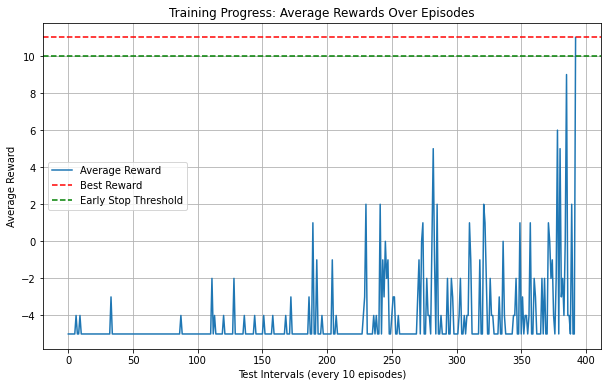

In [45]:
import matplotlib.pyplot as plt

# Print the best average reward
print(f"The best average reward achieved during training: {best_reward:.2f}")

# Plot average rewards over episodes
plt.figure(figsize=(10, 6))
plt.plot(avg_rewards_list, label="Average Reward")
plt.axhline(y=best_reward, color="r", linestyle="--", label="Best Reward")
plt.axhline(y=early_stop_reward, color="g", linestyle="--", label="Early Stop Threshold")
plt.title("Training Progress: Average Rewards Over Episodes")
plt.xlabel("Test Intervals (every 10 episodes)")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()

The plotted results show the agent’s training progression, with average rewards steadily improving over time. Although the reward fluctuates during training, the agent achieves significant peaks as it learns better strategies. The best reward (red dashed line) approaches the early stop threshold (green dashed line), indicating that the PPO algorithm effectively enables the agent to achieve high performance in the Flappy Bird task. The visible reward spikes demonstrate the agent’s capacity to generalize and adapt to the environment.